In [6]:
from lightning import Trainer
import torch
from torch import nn
import lightning as L
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

import matplotlib.pyplot as plt


class SIM_EndToEnd(L.LightningModule):
    def __init__(self, latent_dims: list, beta: float = 1.0):
        super(SIM_EndToEnd, self).__init__()
        self.latent_dims = latent_dims
        self.beta = beta

        # Encoder layers. Each layer will be a reparameterization layer
        layers = []
        prev_dim = 28 * 28
        for latent_dim in latent_dims:
            layers.append(nn.Linear(prev_dim, latent_dim * 2))  # *2 for mu and log_var
            prev_dim = latent_dim
        self.layers = nn.ModuleList(layers)


        self.final_layer = nn.Sequential(nn.Linear(prev_dim, 28 * 28), nn.Sigmoid())

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):  # forward through all layers and apply after each layer a  reparameterization layer
        mu_log_vars = []
        for layer in self.layers:
            mu_log_var = layer(x)
            mu, log_var = torch.chunk(mu_log_var, 2, dim=1)
            x = self.reparameterize(mu, log_var)
            x = torch.nn.functional.leaky_relu(x)
            mu_log_vars.append((mu, log_var))

        return self.final_layer(x), mu_log_vars

    def training_step(self, batch, batch_idx):
        x, _ = batch
        x = x.view(x.size(0), -1)
        x_hat, mu_log_vars = self(x)
        x_hat = x_hat.view(x.size(0), 28, 28)
        x = x.view(x.size(0), 28, 28)

        recon_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
        kl_div = sum(-0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
                     for mu, log_var in mu_log_vars)
        loss = recon_loss + self.beta * kl_div

        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


# Prepare the data
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = MNIST("../data", train=True, download=True, transform=transform)
mnist_val = MNIST("../data", train=False, download=True, transform=transform)

train_loader = DataLoader(mnist_train, batch_size=32)
val_loader = DataLoader(mnist_val, batch_size=32)

# Initialize our model
multi_layer_beta_vae = SIM_EndToEnd(latent_dims=[20, 10, 20], beta=0.1)

# Initialize a trainer
trainer = Trainer(max_epochs=10, fast_dev_run=False)

# Train the model
trainer.fit(multi_layer_beta_vae, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Python\Python39\lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type       | Params
-------------------------------------------
0 | layers      | ModuleList | 32.3 K
1 | final_layer | Sequential | 16.5 K
-------------------------------------------
48.7 K    Trainable params
0         Non-trainable params
48.7 K    Total params
0.195     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


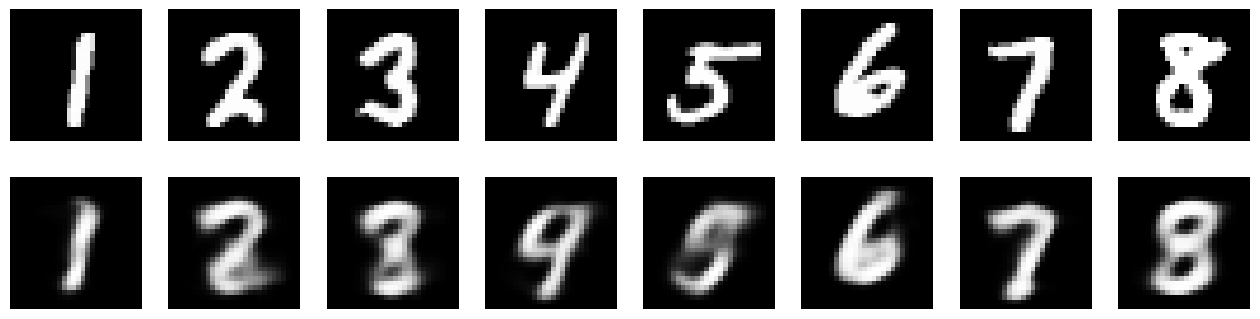

In [7]:
# Function to display a few reconstructions and their ground truth in a grid
def display_reconstructions(model, data_loader, num_images=8):
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            x, _ = batch
            x_hat = model(x.view(x.size(0), -1))[0].view(-1, 1, 28, 28)

    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))
    for i in range(num_images):
        axes[0, i].imshow(x[i].squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(x_hat[i].squeeze(), cmap='gray')
        axes[1, i].axis('off')
    plt.show()


# Display reconstructions
display_reconstructions(multi_layer_beta_vae, val_loader)

In [8]:
import graphviz

def visualize_architecture(latent_dims):
    dot = graphviz.Digraph(graph_attr={'rankdir': 'LR'})  # Set the graph direction to Left to Right

    # Input node
    dot.node('Input', 'Input (28x28)')

    # Encoder layers with reparameterization
    prev_dim = 'Input'
    for i, latent_dim in enumerate(latent_dims):
        linear_name = f'Linear_{i}'
        mu_name = f'Mu_{i}'
        sigma_name = f'Sigma_{i}'
        reparam_name = f'Reparam_{i}'

        dot.node(linear_name, f'Linear ({latent_dim * 2})')
        dot.node(mu_name, f'Mu ({latent_dim})')
        dot.node(sigma_name, f'Sigma ({latent_dim})')
        dot.node(reparam_name, f'Reparam ({latent_dim})')

        dot.edge(prev_dim, linear_name)
        dot.edge(linear_name, mu_name)
        dot.edge(linear_name, sigma_name)
        dot.edge(mu_name, reparam_name)
        dot.edge(sigma_name, reparam_name)

        prev_dim = reparam_name

    # Final layer
    dot.node('Output', 'Output (28x28)')
    dot.edge(prev_dim, 'Output')

    return dot

# Visualize the architecture
latent_dims = [20, 10, 20]
dot = visualize_architecture(latent_dims)
dot.render('architecture', format='png', view=True)

'vae_architecture.png'